# Aggregate cell profiles to well-level profiles

In [118]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from collections import defaultdict
import umap
from functools import reduce
import operator
import random
%matplotlib inline

np.random.seed(0)
random.seed(0)

controls = {
    "TC": ["EGFP"],
    "NC": ["RHEB", "MAPK9", "PRKACB", "SLIRP"],
    "PC": ["ALK", "ALK_Arg1275Gln", "PTK2B"],
    # "cPC": ["KRAS", "PTK2B", "GHSR", "ABL1", "BRD4", 
    # "OPRM1", "RB1", "ADA", "WT PMP22", "LYN", "TNF", 
    # "CYP2A6", "CSK", "PAK1", "ALDH2", "CHRM3", "KCNQ2", 
    # "ALK T1151M", "PRKCE", "LPAR1", "PLP1"]
}

ctrl_alleles = [k_v for k_v in controls.values()]
ctrl_alleles_flat = [allele for sublist in ctrl_alleles for allele in sublist]
ctrl_alleles_flat

BATCH_LIST = [
    "2024_01_23_Batch_7", "2024_02_06_Batch_8",
    "2024_12_09_Batch_11", "2024_12_09_Batch_12",
    "2025_01_27_Batch_13", "2025_01_28_Batch_14",
    "2025_03_17_Batch_15", "2025_03_17_Batch_16"
]
BIO_BATCHES = ["2024_02_Batch_7-8", "2024_12_Batch_11-12", "2025_01_Batch_13-14", "2025_03_Batch_15-16"]

## 1. Get the allele info

In [2]:
misloc_alleles = []

for batch in BIO_BATCHES:
    misloc_alleles_df = pl.read_csv(f"../../outputs/{batch}/altered_local_summary_auroc.csv")
    allele_qc_df = pl.read_csv(f"../../outputs/{batch}/well-level_img_qc_gfp_sum.csv")
    # Step 1: Filter only rows with PASS
    allele_qc_df_pass = allele_qc_df.filter(pl.col("QC_Flag")=="PASS")
    # Step 2: Group by gene_allele and Batch, count occurrences
    df_grouped = allele_qc_df_pass.select([
        pl.col("gene_allele"),
        pl.col("Batch"),
        pl.col("QC_Flag")
    ]).unique()
    # Step 3: Pivot to wide format
    df_pivot = df_grouped.pivot(
        values="QC_Flag",
        index="gene_allele",
        on="Batch"
    )
    # Step 4: Filter alleles with PASS in both batches
    # (They will have non-null values in both columns)
    # Step 4: Build filter expression dynamically for non-null in all batches
    batches = allele_qc_df_pass.select("Batch").unique().get_column("Batch").to_list()
    # Step 4: Dynamically build filter expression to check non-null in all batches
    filter_expr = reduce(
        operator.and_,
        [pl.col(batch).is_not_null() for batch in batches]
    )
    # Step 5: Apply filter to get only alleles with PASS in all batches
    df_result = df_pivot.filter(filter_expr)
    misloc_alleles_pass = misloc_alleles_df.filter(
        (pl.col("allele_0").is_in(df_result["gene_allele"])) & (pl.col("Altered_local_both_batches"))
    )
    misloc_alleles += misloc_alleles_pass["allele_0"].unique().to_list()

misloc_ref_gene = list(set([gene_allele.split('_')[0] for gene_allele in misloc_alleles]))
misloc_ref_var_alleles = misloc_ref_gene + misloc_alleles
misloc_ref_var_alleles

['CTNNA3',
 'DES',
 'KCTD7',
 'IL2RG',
 'TAT',
 'RET',
 'NR0B1',
 'EMD',
 'SDHD',
 'SFTPC',
 'WRAP53',
 'SMN2',
 'ACSF3',
 'XRCC2',
 'FANCC',
 'TTPA',
 'DCX',
 'SH3BP2',
 'PMP22',
 'CTCF',
 'MVK',
 'SFTPA2',
 'CDC73',
 'HBD',
 'ZC4H2',
 'TPM1',
 'CDKN1A',
 'BFSP2',
 'RAF1',
 'BRIP1',
 'GFAP',
 'RAB33B',
 'CRADD',
 'RHO',
 'EFHC1',
 'CLDN19',
 'TMEM43',
 'HGD',
 'ASNS',
 'PKP2',
 'FXN',
 'LIG4',
 'AGXT',
 'FOXP3',
 'SMAD3',
 'IMPDH1',
 'TPM3',
 'HPRT1',
 'SOS2',
 'LMNA',
 'NT5C3A',
 'KCNJ2',
 'COMP',
 'SMAD1',
 'MLH1',
 'LITAF',
 'COQ8A',
 'FBP1',
 'SNIP1',
 'RPS19',
 'FH',
 'GMPPB',
 'BRCA1',
 'PLA2G6',
 'FADD',
 'RP2',
 'PNPO',
 'STXBP1',
 'AIPL1',
 'CCM2',
 'F9',
 'XPA',
 'KRT4',
 'KRT6A',
 'KCTD7_Asn273Ile',
 'EFHC1_Cys259Tyr',
 'COMP_Thr585Arg',
 'HPRT1_Gly70Glu',
 'DCX_Thr203Ala',
 'EFHC1_Met448Thr',
 'DES_Asn342Asp',
 'IL2RG_Ser108Pro',
 'DES_Ala337Pro',
 'PNPO_Arg95Cys',
 'TTPA_Gly246Arg',
 'ACSF3_Ser431Tyr',
 'DES_Val126Leu',
 'DCX_Tyr125His',
 'TAT_Pro220Ser',
 'SFTPC_Leu188Gl

In [30]:
len(misloc_alleles)

281

In [31]:
len(misloc_ref_gene)

74

## 2. Reading the cell profiles

In [26]:
# Paths
pass_qc_prof_pq_path = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles_tcdropped_filtered_var_mad_outlier_featselect_filtcells.parquet"
misloc_allele_cell_qc_profile_df = pl.DataFrame()

# Get meta features
for batch_id in BATCH_LIST:
    batch_alleles = (
        pl.scan_parquet(
            pass_qc_prof_pq_path.format(batch_id=batch_id)
        )
        .filter(pl.col("Metadata_gene_allele").is_in(misloc_ref_var_alleles))
        .with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
        .select([
            "Metadata_CellID",
            "Metadata_gene_allele",
            "Metadata_Well",
            "Metadata_Plate",
            "Metadata_node_type"
        ])
    )
    misloc_allele_cell_qc_profile_df = pl.concat([misloc_allele_cell_qc_profile_df, batch_alleles.collect()])

In [27]:
# Paths
prof_pq_path = "../../../8.2_updated_snakemake_pipeline/outputs/batch_profiles/{batch_id}/profiles.parquet"
misloc_allele_cell_all_profiles = []

# Get meta features
for batch_id in BATCH_LIST:
    batch_alleles = (
        pl.scan_parquet(
            prof_pq_path.format(batch_id=batch_id)
        )
        .filter(pl.col("Metadata_gene_allele").is_in(misloc_ref_var_alleles))
        .with_columns(
            pl.concat_str(
                [
                    "Metadata_Plate",
                    "Metadata_Well",
                    "Metadata_ImageNumber",
                    "Metadata_ObjectNumber",
                ],
                separator="_",
            ).alias("Metadata_CellID")
        )
    )
    misloc_allele_cell_all_profiles.append(batch_alleles)
    

gfp_feats = [i for i in misloc_allele_cell_all_profiles[0].collect_schema() if "GFP" in i and "Brightfield" not in i]
gfp_feats = ["Metadata_CellID"] + gfp_feats

misloc_allele_cell_profile_all_df = pl.concat([batch_alleles.select(gfp_feats).collect() for batch_alleles in misloc_allele_cell_all_profiles])

# This method of joining ensures that only cells past filters are included in the abundance analysis
misloc_allele_cell_profile_df = misloc_allele_cell_qc_profile_df.join(misloc_allele_cell_profile_all_df.select(gfp_feats), on="Metadata_CellID", how="left")

In [28]:
misloc_allele_cell_profile_df.shape

(1403582, 764)

## 3. Processing and profiling

### 3.1 Aggregate features to well-level

In [144]:
def remove_corr_feats(df, corr_thres=.8):
    # 2. Identify numeric columns
    all_num_feats = [
        name
        for name, dtype in df.schema.items()
        if dtype in (pl.Int8, pl.Int16, pl.Int32, pl.Int64, pl.Float32, pl.Float64)
    ]
    # 3. Bring that slice into pandas
    pdf = df.select(all_num_feats).to_pandas()
    # 4. Compute absolute correlation matrix
    corr = pdf.corr().abs()
    # 5. Mask out the lower triangle (we only need one side)
    upper = corr.where(
        np.triu(np.ones(corr.shape), k=1).astype(bool)
    )
    # 6. Pick columns to drop: any column with correlation > threshold to *any* other
    to_drop = [col for col in upper.columns if any(upper[col] > corr_thres)]
    # 7. Drop them in your original Polars DF
    df_drop_corr_cols = df.drop(to_drop)

    # colocal_col_cat = set(["_".join(col.split('_')[1:3]) for col in colocal_cols])
    # print(colocal_col_cat)
    # colocal_col_dict = defaultdict(list)
    # for col in colocal_cols:
    #     colocal_col_dict["_".join(col.split('_')[1:3])].append(col)
    # colocal_col_dict

    return df_drop_corr_cols

In [145]:
misloc_allele_well_profile_df = (
    misloc_allele_cell_profile_df.group_by(["Metadata_Plate", "Metadata_Well", "Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in misloc_allele_cell_profile_df.columns
        if not col.startswith("Metadata_")
    )
    .unique()
    .drop_nulls("Metadata_gene_allele")
)

misloc_allele_well_profile_df = misloc_allele_well_profile_df.with_columns(
    pl.col("Metadata_Plate")
      # capture a “B” followed by any non-underscore chars up to the first “A”
      .str.extract(r"(B[^_]*?A)", 1)
      .alias("Metadata_Batch")
)#.select("Metadata_Plate")

misloc_allele_well_profile_no_corr_df = remove_corr_feats(misloc_allele_well_profile_df)

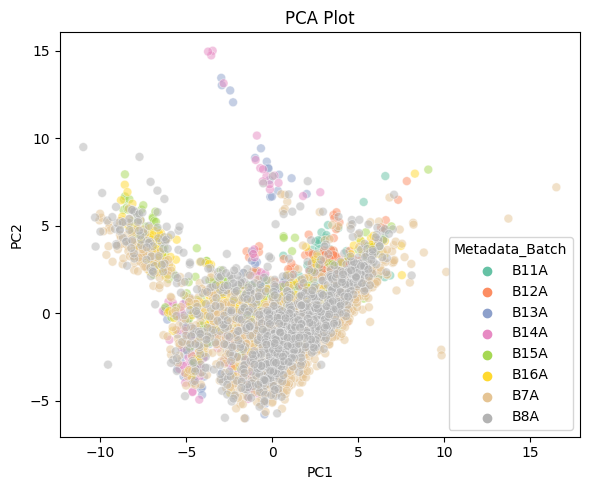

In [151]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Perform UMAP
# Perform PCA
df = misloc_allele_well_profile_no_corr_df.select(pl.col([col for col in misloc_allele_well_profile_no_corr_df.columns if not col.startswith("Metadata_")]))

# Standardize the features before PCA
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

pca = PCA(n_components=10)
pca_result = pca.fit_transform(df)

pca_df = pd.DataFrame(pca_result, columns=[f"PC{i+1}" for i in range(pca_result.shape[1])])
pca_df["Metadata_gene_allele"] = misloc_allele_well_profile_no_corr_df["Metadata_gene_allele"].to_numpy()
pca_df["Metadata_Batch"] = misloc_allele_well_profile_no_corr_df["Metadata_Batch"].to_numpy()
# pca_df["Metadata_variant_type"] = misloc_allele_well_profile_gfp_nocorr["Metadata_variant_type"].to_numpy()
# pca_df["Metadata_control_type"] = misloc_allele_well_profile_gfp_nocorr["Metadata_control_type"].to_numpy()

# Plot UMAP
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.scatterplot(data=pca_df.sort_values(by="Metadata_Batch"), alpha=.5,
                x="PC1", y="PC2", hue="Metadata_Batch", palette="Set2", s=40, ax=ax) ## hue=variant_type, 
# texts = []
# for i, label in enumerate(group2_labels):
#     if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#         texts.append(ax.text(umap_result[i, 0], umap_result[i, 1], label, 
#                      fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax) ## 
ax.set_title("PCA Plot")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(title="Metadata_Batch")
plt.tight_layout()
plt.show()

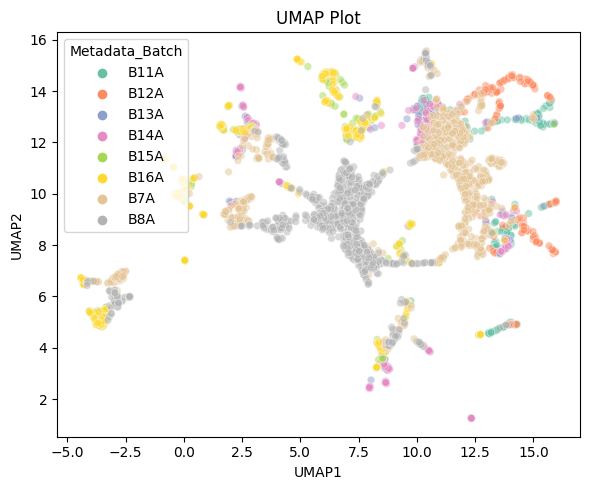

In [153]:
# from sklearn.preprocessing import StandardScaler

# Perform UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, n_jobs=1)
df = misloc_allele_well_profile_no_corr_df.select(pl.col([col for col in misloc_allele_well_profile_no_corr_df.columns if not col.startswith("Metadata_")]))

# Standardize the features before PCA
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
umap_result = umap_model.fit_transform(df.to_numpy())
umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
umap_df["Metadata_Batch"] = misloc_allele_well_profile_no_corr_df["Metadata_Batch"].to_numpy()
# umap_df["Metadata_variant_type"] = well_profiles_plate_agg["Metadata_variant_type"].to_numpy()
# umap_df["Metadata_control_type"] = well_profiles_plate_agg["Metadata_control_type"].to_numpy()

# Plot UMAP
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.scatterplot(data=umap_df.sort_values(by="Metadata_Batch"), x="UMAP1", y="UMAP2", hue="Metadata_Batch", palette="Set2", alpha=.5, s=30, ax=ax) ## hue=variant_type, 
# texts = []
# for i, label in enumerate(group2_labels):
#     if label in misloc_binary.filter(pl.col("mislocalized_both_batches"))["allele_0"]:
#         texts.append(ax.text(umap_result[i, 0], umap_result[i, 1], label, 
#                      fontsize=6, fontweight='bold', color='black'))
# adjust_text(texts, expand_points=(2, 2), arrowprops=dict(arrowstyle='-', color='red', lw=0.5), ax=ax) ## 
ax.set_title("UMAP Plot")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
ax.legend(title="Metadata_Batch")
plt.tight_layout()
plt.show()

### 3.2 VAR Profiles - WT Profiles

In [46]:
misloc_allele_profile_df = (
    misloc_allele_cell_profile_df.group_by(["Metadata_gene_allele"])
    .agg(
        pl.col(col).median().alias(col)
        for col in misloc_allele_cell_profile_df.columns
        if not col.startswith("Metadata_")
    )
    .unique()
    .drop_nulls("Metadata_gene_allele")
)
misloc_allele_profile_df_nocorr = remove_corr_feats(misloc_allele_profile_df).to_pandas()

In [96]:
misloc_allele_profile_df_nocorr_wt = misloc_allele_profile_df_nocorr[~misloc_allele_profile_df_nocorr["Metadata_gene_allele"].str.contains("_")].copy().set_index("Metadata_gene_allele")
misloc_allele_profile_df_nocorr_var = misloc_allele_profile_df_nocorr[misloc_allele_profile_df_nocorr["Metadata_gene_allele"].str.contains("_")].copy()
misloc_allele_profile_df_nocorr_var["Gene"] = misloc_allele_profile_df_nocorr_var["Metadata_gene_allele"].apply(lambda x: x.split("_")[0])

misloc_allele_var_minus_wt = pd.DataFrame()
for gene, group in misloc_allele_profile_df_nocorr_var.groupby("Gene"):
    # print(gene)
    # display(misloc_allele_profile_df_nocorr_wt.loc[gene])
    group = group.set_index("Metadata_gene_allele").drop("Gene", axis=1).copy()
    g_col = group.columns
    # display(group)
    group = group - misloc_allele_profile_df_nocorr_wt.loc[gene]
    # display(misloc_allele_profile_df_nocorr_wt.loc[[gene]])
    misloc_allele_var_minus_wt = pd.concat([misloc_allele_var_minus_wt, group], axis=0)
    # display(misloc_allele_var_minus_wt)

display(misloc_allele_var_minus_wt)

,Cytoplasm_Correlation_Correlation_AGP_GFP,Cytoplasm_Correlation_Correlation_DNA_GFP,Cytoplasm_Correlation_Correlation_GFP_Mito,Cytoplasm_Correlation_Costes_AGP_GFP,Cytoplasm_Correlation_Costes_DNA_GFP,Cytoplasm_Correlation_Costes_GFP_AGP,Cytoplasm_Correlation_Costes_GFP_DNA,Cytoplasm_Correlation_Costes_GFP_Mito,Cytoplasm_Correlation_Costes_Mito_GFP,Cytoplasm_Correlation_K_AGP_GFP,...,Nuclei_Correlation_Correlation_AGP_GFP,Nuclei_Correlation_Costes_AGP_GFP,Nuclei_Correlation_Costes_GFP_DNA,Nuclei_Correlation_Costes_GFP_Mito,Nuclei_Correlation_Manders_GFP_AGP,Nuclei_Correlation_Manders_GFP_DNA,Nuclei_Correlation_Manders_GFP_Mito,Nuclei_Correlation_RWC_GFP_AGP,Nuclei_Location_CenterMassIntensity_Z_GFP,Nuclei_Location_MaxIntensity_Z_GFP
Metadata_gene_allele,,,,,,,,,,,,,,,,,,,,,
ACSF3_Arg471Trp,-0.311255,0.033815,0.346789,-0.012034,-0.005664,0.0,0.243556,0.000000,0.000000,-0.016370,...,0.031543,0.0,0.0,0.0,0.0,0.0,0.0,0.036861,0.0,0.0
ACSF3_Asp457Asn,-0.321506,0.041608,0.352543,-0.002820,-0.001617,0.0,0.151169,0.000000,-0.000535,-0.013085,...,-0.009136,0.0,0.0,0.0,0.0,0.0,0.0,0.020330,0.0,0.0
ACSF3_Arg558Trp,-0.283356,0.036592,0.330083,-0.006476,-0.008496,0.0,0.392557,0.000000,-0.000199,-0.013200,...,0.042338,0.0,0.0,0.0,0.0,0.0,0.0,0.026837,0.0,0.0
ACSF3_Thr358Ile,-0.265848,0.053853,0.347434,-0.002792,-0.002667,0.0,0.485437,0.000000,-0.000506,-0.028199,...,0.046355,0.0,0.0,0.0,0.0,0.0,0.0,0.023719,0.0,0.0
ACSF3_Gly119Asp,-0.239896,0.054732,0.349890,-0.012564,-0.007976,0.0,0.106929,0.000000,-0.000077,-0.021665,...,0.024986,0.0,0.0,0.0,0.0,0.0,0.0,0.039483,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WRAP53_Arg398Trp,-0.089012,-0.043390,-0.033602,0.000000,-0.001167,0.0,-0.248841,0.000000,0.000000,-0.225796,...,0.007897,0.0,0.0,0.0,0.0,0.0,0.0,-0.004930,0.0,0.0
XPA_Cys108Phe,-0.026587,-0.292183,0.262380,-0.046409,-0.055165,0.0,-0.437555,0.001814,0.009627,0.139179,...,0.684703,0.0,0.0,0.0,0.0,0.0,0.0,0.069812,0.0,0.0
XRCC2_Phe270Val,-0.027998,-0.050830,0.000629,-0.004251,-0.006662,0.0,0.072001,0.000000,0.000000,-0.047475,...,0.235152,0.0,0.0,0.0,0.0,0.0,0.0,0.015723,0.0,0.0


In [ ]:
# misloc_allele_var_minus_wt.to_csv("test.csv")

In [101]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AffinityPropagation
from sklearn.mixture import BayesianGaussianMixture

# Suppose `df_feat` is your feature DataFrame (samples × features)
X = misloc_allele_var_minus_wt.values  # shape (n_samples, n_features)

# Compute the full cosine similarity matrix
sim_matrix = cosine_similarity(X)  # dense ndarray, shape (n_samples, n_samples)  [oai_citation:5‡Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html?utm_source=chatgpt.com)

# Optional: force values into [0,1]
# sim_matrix = np.clip(sim_matrix, 0, 1)  # ensures numerical stability  [oai_citation:6‡Data Science Portfolio](https://danielcaraway.github.io/html/sklearn_cosine_similarity.html?utm_source=chatgpt.com)

ap_clusterer = AffinityPropagation(affinity='precomputed', random_state=42)
ap_labels = ap_clusterer.fit_predict(sim_matrix)

# 4. Bayesian Gaussian Mixture (Dirichlet Process) clustering
bgm = BayesianGaussianMixture(
    n_components=10,
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=0.01,
    random_state=42
)
bgm_labels = bgm.fit_predict(X)

In [102]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

silhouette_scores = []
cluster_range = range(2, 10)  # Trying clusters from 2 to 9
df = misloc_allele_var_minus_wt.dropna(axis=1).copy()

for k in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = clustering.fit_predict(df)
    score = silhouette_score(df, labels)
    silhouette_scores.append(score)
    print(f"Clusters: {k}, Silhouette Score: {score:.4f}")

# Select the number of clusters that has the highest silhouette score
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters determined: {optimal_clusters}")

agg_model = AgglomerativeClustering(n_clusters=3, linkage='ward')
df.loc[:,'cluster'] = agg_model.fit_predict(df)

df.loc[:,'bgm_cluster'] = bgm_labels
df.loc[:,'ap_cluster'] = ap_labels

Clusters: 2, Silhouette Score: 0.3732
Clusters: 3, Silhouette Score: 0.3130
Clusters: 4, Silhouette Score: 0.3214
Clusters: 5, Silhouette Score: 0.2761
Clusters: 6, Silhouette Score: 0.2713
Clusters: 7, Silhouette Score: 0.2722
Clusters: 8, Silhouette Score: 0.2788
Clusters: 9, Silhouette Score: 0.2823
Optimal number of clusters determined: 2


In [88]:
# import scipy.sparse as sp
# import numpy as np
# from umap.umap_ import nearest_neighbors  # UMAP precomputed-kNN helper  [oai_citation:7‡UMAP Documentation](https://umap-learn.readthedocs.io/en/latest/precomputed_k-nn.html?utm_source=chatgpt.com)
# from hidef import utils

# # Assume `df_feat` is a Polars DataFrame of shape (n_samples, n_features)
# # Convert to NumPy
# X = misloc_allele_var_minus_wt.to_numpy()  # zero-copy when possible  [oai_citation:8‡Polars User Guide](https://docs.pola.rs/docs/python/version/0.19/reference/dataframe/api/polars.DataFrame.to_numpy.html?utm_source=chatgpt.com)

# # 1. Compute kNN graph with UMAP (fuzzy simplicial set)
# knn_distances, knn_indices, _ = nearest_neighbors(
#     X,
#     n_neighbors=15,
#     metric="euclidean",
#     random_state=42
# )  # returns distances & neighbor indices  [oai_citation:9‡HiDeF](https://hidef.readthedocs.io/en/latest/tutorial/community.html) [oai_citation:10‡UMAP Documentation](https://umap-learn.readthedocs.io/en/latest/api.html?utm_source=chatgpt.com)

# # 2. Build sparse kNN matrix
# row_idx = np.repeat(np.arange(X.shape[0]), knn_indices.shape[1])
# col_idx = knn_indices.ravel()
# data = np.ones_like(row_idx, dtype=float)
# mat_knn = sp.csr_matrix((data, (row_idx, col_idx)), shape=(X.shape[0], X.shape[0]))

# # 3. Convert kNN → sNN via Jaccard similarity
# indices = utils.jaccard_matrix(mat_knn, mat_knn, threshold=0.1)
# # `indices` is a tuple of (row_inds, col_inds) for edges in the sNN graph  [oai_citation:11‡HiDeF](https://hidef.readthedocs.io/en/latest/tutorial/community.html)
# with open("snn_edges.tsv", "w") as fh:
#     for i, j in zip(indices[0], indices[1]):
#         fh.write(f"{i}\t{j}\n")

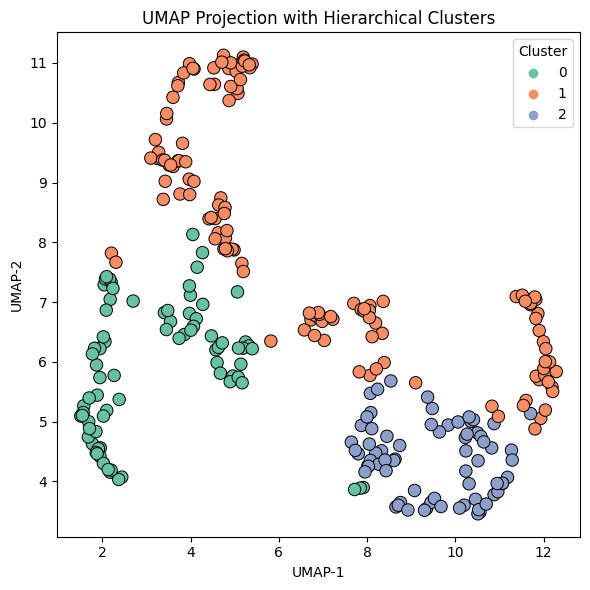

In [127]:
# ----------------------------
# 4. Compute UMAP Projection and Plot the Clusters
# ----------------------------
np.random.seed(0)
umap_reducer = umap.UMAP(random_state=0, n_jobs=1)
embedding = umap_reducer.fit_transform(df)
df.loc[:,'UMAP-1'] = embedding[:, 0]
df.loc[:,'UMAP-2'] = embedding[:, 1]

plt.figure(figsize=(6, 6))
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='cluster', 
                palette='Set2', data=df, s=80, edgecolor='k')
plt.title("UMAP Projection with Hierarchical Clusters")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()